In [1]:
import pandas as pd

In [8]:
df = pd.read_csv("StudyEventTimeSeries 1.10.52 PM.csv")

In [9]:
import numpy as np

In [10]:
codelist = list(set(df.as_matrix().flatten()))
codelist.remove(np.nan)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [11]:
featureOnly= list(filter(lambda x: x.isupper(),codelist))
themeOnly= list(filter(lambda x: x.islower(),codelist))

In [12]:
# df["t"]=df.index

In [13]:
df = df.stack().reset_index()

In [14]:
df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

In [15]:
import altair as alt

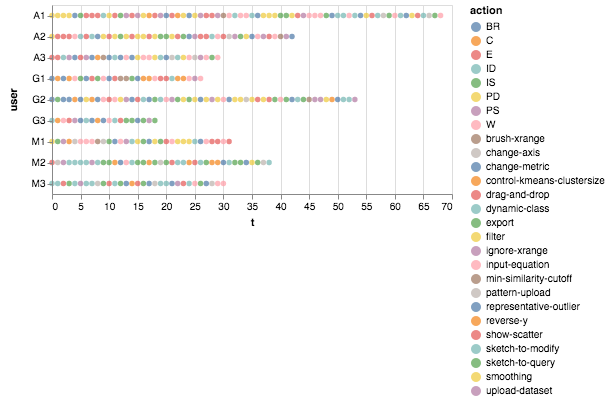

In [16]:
alt.Chart(df).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

# Action only

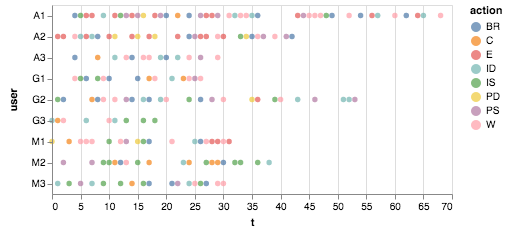

In [17]:
df_action = df[df.action.isin(featureOnly)]
alt.Chart(df_action).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

# Feature Only

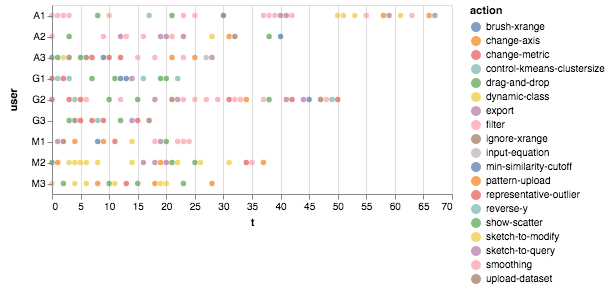

In [18]:
df_feature = df[~df.action.isin(featureOnly)]
alt.Chart(df_feature).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

In [19]:
# df_feature = df[~df.action.isin(featureOnly)]

# Key Components

In [20]:
component_dict = {
     'pattern-upload':'concept-query',
     'sketch-to-modify':'exact-specification',
     'drag-and-drop':'result-querying',
     'change-metric':'flexible-matching',
     'filter':'filter-selection',
     'brush-xrange':'range-selection',
     'min-similarity-cutoff':'control',
     'smoothing':'approx-shape-specification',
     'ignore-xrange':'approx-shape-specification',
     'representative-outlier':'recommendation',
     'dynamic-class':'group-comparison',
     'sketch-to-query':'exact-specification',
     'reverse-y':'control',
     'input-equation':'exact-specification',
     'upload-dataset':'control',
     'show-scatter':'control',
     'export':'control',
     'control-kmeans-clustersize':'recommendation',
     'change-axis':'control'
}

In [21]:
df_component = df_feature
df_component["action"] = df_feature["action"].replace(component_dict)
df_component= df_component.rename(index=str,columns={"action":"component"})

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
df_component = df_component[df_component["component"]!="control"] #remove control in list of components

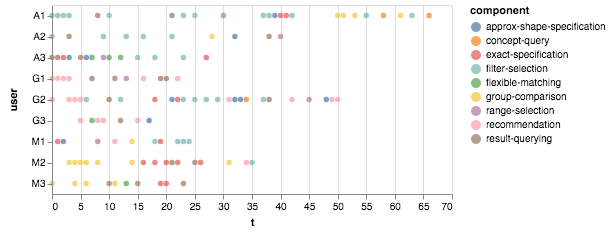

In [23]:
alt.Chart(df_component).mark_circle().encode(        
    color='component',
    y="user",
    x='t'
)

# Adding some event action information back in

In [24]:
component_chart = alt.Chart(df_component).mark_circle().encode(        
    color='component',
    y="user",
    x='t'
)

In [25]:
df_break = df[df.action.isin(["BR"])]
break_chart = alt.Chart(df_action).mark_tick(thickness=2,color="black").encode(        
    y="user",
    x='t'
)

In [26]:
df_insight = df[df.action.isin(["IS","ID"])]
insight_chart = alt.Chart(df_insight).mark_point().encode(        
    shape='action',
    y="user",
    x='t'
)

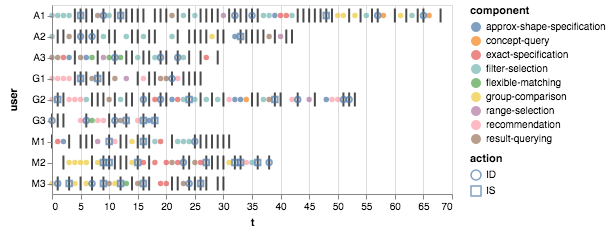

In [28]:
component_chart+ break_chart + insight_chart